Paper Source

"Step-by-Step HHL Algorithm Walkthrough to Enhance the Understanding of Critical Quantum Computing Concepts"

https://arxiv.org/abs/2108.09004

<b>To cite</b>

Hector Morrell and Hiu Yung Wong, "Step-by-Step HHL Algorithm Walkthrough to Enhance the Understanding of Critical Quantum Computing Concepts", arXiv preprint arXiv:2108.09004


In [6]:
#!pip install qiskit[visualization]

# Imports for Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import *
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np

# Various imports 
import numpy as np

from copy import deepcopy
from matplotlib import pyplot as plt

#IBMQ.save_account('Put your token')
#provider = IBMQ.load_account()
#IBMQ.get_provider(hub='ibm-q', group='open', project = 'main')

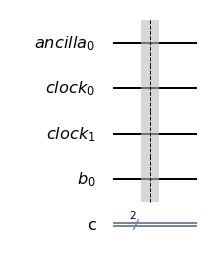

In [7]:
# Create the various registers needed
clock = QuantumRegister(2, name='clock')
input = QuantumRegister(1, name='b')
ancilla = QuantumRegister(1, name='ancilla')
measurement = ClassicalRegister(2, name='c')

# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, clock, input, measurement)

circuit.barrier()
circuit.draw(output='mpl')

In [8]:
def qft_dagger(circ, q, n):      
    circ.h(clock[1]);
    for j in reversed(range(n)):
        for k in reversed(range(j+1,n)):
            circ.cu1(-np.pi/float(2**(k-j)), q[k], q[j]);
    circ.h(clock[0]);
    circ.swap(clock[0], clock[1]);

def qft(circ, q, n):
    circ.swap(clock[0], clock[1]);
    circ.h(clock[0]);
    for j in reversed(range(n)):
        for k in reversed(range(j+1,n)):
            circ.cu1(np.pi/float(2**(k-j)), q[k], q[j]);
    circ.h(clock[1]);

In [9]:
def qpe(circ, clock, target):
    circuit.barrier()

    # e^{i*A*t}
    circuit.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, clock[0], input, label='U');
    
    # e^{i*A*t*2}
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2');

    circuit.barrier();
    
    # Perform an inverse QFT on the register holding the eigenvalues
    qft_dagger(circuit, clock, 2)
    
def inv_qpe(circ, clock, target):
    
    # Perform a QFT on the register holding the eigenvalues
    qft(circuit, clock, 2)

    circuit.barrier()

    # e^{i*A*t*2}
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2');

    #circuit.barrier();

    # e^{i*A*t}
    circuit.cu(np.pi/2, np.pi/2, -np.pi/2, -3*np.pi/4, clock[0], input, label='U');

    circuit.barrier()

In [10]:
def hhl(circ, ancilla, clock, input, measurement):
    
    qpe(circ, clock, input)

    circuit.barrier()
    
    # This section is to test and implement C = 1
    circuit.cry(np.pi, clock[0], ancilla)
    circuit.cry(np.pi/3, clock[1], ancilla)

    circuit.barrier()
    
    circuit.measure(ancilla, measurement[0])
    circuit.barrier()
    inv_qpe(circ, clock, input)

In [11]:
# State preparation. 
intial_state = [0,1]
circuit.initialize(intial_state, 3)

circuit.barrier()

# Perform a Hadamard Transform
circuit.h(clock)

hhl(circuit, ancilla, clock, input, measurement)

# Perform a Hadamard Transform
circuit.h(clock)

circuit.barrier()


circuit.measure(input, measurement[1])

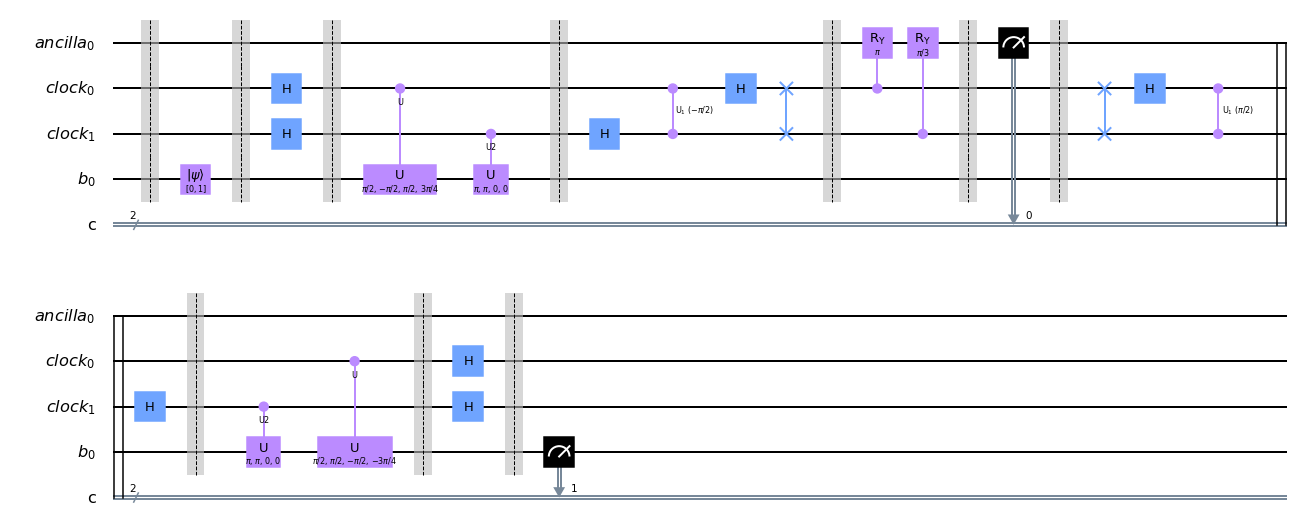

In [12]:
circuit.draw('mpl',scale=1)

In [ ]:
# Execute the circuit using the simulator
simulator = qiskit.BasicAer.get_backend('qasm_simulator')
job = execute(circuit, backend=simulator, shots=65536)

#Get the result of the execution
result = job.result()

# Get the counts, the frequency of each answer
counts = result.get_counts(circuit)

# Display the results
plot_histogram(counts)

In [ ]:
bcknd = Aer.get_backend('statevector_simulator')

job_sim = execute(circuit, bcknd)
result = job_sim.result()

o_state_result = result.get_statevector(circuit, decimals=3)
print(o_state_result)

In [ ]:
provider.backends()

# Choose the backend on which to run the circuit
backend = provider.get_backend('ibmq_santiago')

from qiskit.tools.monitor import job_monitor

# Execute the job
job_exp = execute(circuit, backend=backend, shots=8192)

# Monitor the job to know where we are in the queue
job_monitor(job_exp, interval = 2)

In [ ]:
# Get the results from the computation
results = job_exp.result()

# Get the statistics
answer = results.get_counts(circuit)

# Plot the results
plot_histogram(answer)